In [66]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [67]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [68]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [33]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [34]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.tools.tavily import TavilySearch

In [35]:
from langchain_openai import ChatOpenAI

In [36]:
from langchain_teddynote.graphs import visualize_graph

In [37]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [38]:
######### 2. 도구 정의 및 바인딩 #########

tool = TavilySearch(max_results=1)
tools = [tool]

In [39]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [40]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')

    return {'messages': [answer]}

In [41]:
graph_builder = StateGraph(State)

In [42]:
graph_builder.add_node('chatbot', chatbot)

In [43]:
tool_node = ToolNode(tools=[tool])

In [44]:
graph_builder.add_node('tools', tool_node)

In [45]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [46]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [47]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [48]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [49]:
graph = graph_builder.compile(checkpointer=memory)

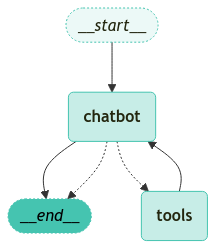

In [50]:
visualize_graph(graph)

In [51]:
from langchain_core.runnables import RunnableConfig

In [52]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

In [53]:
question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    
    print('[event] 실행 결과')

    for value in event.values():
        print('[value]: ')
        print(value['messages'][-1])
        
        print(f"\t[content]: {value['messages'][-1].content}")

        print(f"\t[additional_kwargs]: ")
        print(f"\t\t{value['messages'][-1].additional_kwargs}")

        print('\t\t[token_usage]: ')
        # print(f"\t\t\t {value['messages'][-1].response_metadata['token_usage']}")
        print(f"\t\t\t[completion_tokens]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens']}")
        print(f"\t\t\t[prompt_tokens]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens']}")
        print(f"\t\t\t[total_tokens]: {value['messages'][-1].response_metadata['token_usage']['total_tokens']}")
        print(f"\t\t\t[completion_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['completion_tokens_details']}")
        print(f"\t\t\t[prompt_tokens_details]: {value['messages'][-1].response_metadata['token_usage']['prompt_tokens_details']}")

        print(f"\t\t[model_name]: {value['messages'][-1].response_metadata['model_name']}")
        print(f"\t\t[system_fingerprint]: {value['messages'][-1].response_metadata['system_fingerprint']}")
        print(f"\t\t[finish_reason]: {value['messages'][-1].response_metadata['finish_reason']}")        
        
        print('\t[id]: ')
        print(f"\t\t {value['messages'][-1].id}")

        
        print('\t[usage_metadata]: ')
        print(f"\t\t[input_tokens]: {value['messages'][-1].usage_metadata['input_tokens']}")
        print(f"\t\t[output_tokens]: {value['messages'][-1].usage_metadata['output_tokens']}")
        print(f"\t\t[total_tokens]: {value['messages'][-1].usage_metadata['total_tokens']}")
        print(f"\t\t[input_token_details]: {value['messages'][-1].usage_metadata['input_token_details']}")
        print(f"\t\t[output_token_details]: {value['messages'][-1].usage_metadata['output_token_details']}")

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746')]

[2] chatbot answer: 
 안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!
[3] answer.additional_kwargs: 
 {'refusal': None}
[event] 실행 결과
[value]: 
content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None} id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0

In [54]:
question = ('`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning

In [55]:
# 이어지는 질문
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    
    print('=================================================================================')
    print('\n[event] 실행 결과')

    for value in event.values():
        print('(1) value : ')
        print(value['messages'][-1])
        print()

        if value['messages'][-1].content is not None:
            print(f"(2) [content]: {value['messages'][-1].content}")
        else:
            print(f"(2) [content]: 없음")


        if value['messages'][-1].additional_kwargs is not None:
            print(f"(3) [additional_kwargs]: ")
            print(f"\t{value['messages'][-1].additional_kwargs}")

        else:
            print(f"(3) [additional_kwargs]: 없음")

        
        if value['messages'][-1].response_metadata is not None:
            print(f"(4) [response_metadata]: ")
            print(f"\t{value['messages'][-1].response_metadata}")
        else:
            print(f"(4)) [response_metadata]: 없음")
        print('=================================================================================')
        print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning

In [56]:
question = "내 이름이 뭐라고 했지?"

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        print(value["messages"][-1])

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning

In [57]:
question = ('대한민국 수도에 대해서 검색해줘')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    
    print('=================================================================================')
    print('\n[event] 실행 결과')

    for value in event.values():
        print('(1) value : ')
        print(value['messages'][-1])
        print()

        if value['messages'][-1].content is not None:
            print(f"(2) [content]: {value['messages'][-1].content}")
        else:
            print(f"(2) [content]: 없음")


        if value['messages'][-1].additional_kwargs is not None:
            print(f"(3) [additional_kwargs]: ")
            print(f"\t{value['messages'][-1].additional_kwargs}")

        else:
            print(f"(3) [additional_kwargs]: 없음")

        
        if value['messages'][-1].response_metadata is not None:
            print(f"(4) [response_metadata]: ")
            print(f"\t{value['messages'][-1].response_metadata}")
        else:
            print(f"(4)) [response_metadata]: 없음")
        print('=================================================================================')
        print()

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning

In [58]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

snapshot = graph.get_state(config=config)

In [59]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'), AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning':

In [60]:
snapshot.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff0105-7027-6ce3-800f-6990cce6a1a2'}}

In [61]:
snapshot.values

{'messages': [HumanMessage(content='`소프트웨어놀이터`에서 코딩강의를 하고 있는 이인환입니다.', additional_kwargs={}, response_metadata={}, id='bfca6d0f-054b-4089-bf5a-767372cde746'),
  AIMessage(content='안녕하세요, 이인환님! 소프트웨어놀이터에서 코딩 강의를 하고 계시다니 멋지네요. 어떤 주제에 대해 강의를 하고 계신가요? 도움이 필요하시거나 궁금한 점이 있다면 말씀해 주세요!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 110, 'total_tokens': 168, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-73d75004-a66f-47ee-a116-417ad502ca7a-0', usage_metadata={'input_tokens': 110, 'output_tokens': 58, 'total_tokens': 168, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessa

In [62]:
snapshot.next

()

In [63]:
snapshot.metadata

{'source': 'loop',
 'writes': {'chatbot': {'messages': [AIMessage(content='대한민국의 수도는 서울특별시입니다. 서울은 한강이 도시를 관통하며, 대한민국의 정치, 경제, 문화의 중심지로 기능하고 있습니다. 서울은 1948년 8월 15일 대한민국 정부 수립 이후 수도로 지정되었으며, 한국전쟁 동안 잠시 부산이 임시 수도로 사용되기도 했습니다. 현재 서울은 다양한 국제 행사와 문화유산이 있는 도시로 알려져 있습니다.\n\n더 자세한 내용은 [위키백과의 한국의 수도](https://ko.wikipedia.org/wiki/한국의_수도)에서 확인하실 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 6205, 'total_tokens': 6339, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-ed8243d4-4a52-4cb4-b324-9a66f93cf455-0', usage_metadata={'input_tokens': 6205, 'output_tokens': 134, 'total_tokens': 6339, 'input_token_details': {'audio': 0, 'cache_read':

In [64]:
snapshot.metadata['writes']['chatbot']['messages'][0]

AIMessage(content='대한민국의 수도는 서울특별시입니다. 서울은 한강이 도시를 관통하며, 대한민국의 정치, 경제, 문화의 중심지로 기능하고 있습니다. 서울은 1948년 8월 15일 대한민국 정부 수립 이후 수도로 지정되었으며, 한국전쟁 동안 잠시 부산이 임시 수도로 사용되기도 했습니다. 현재 서울은 다양한 국제 행사와 문화유산이 있는 도시로 알려져 있습니다.\n\n더 자세한 내용은 [위키백과의 한국의 수도](https://ko.wikipedia.org/wiki/한국의_수도)에서 확인하실 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 134, 'prompt_tokens': 6205, 'total_tokens': 6339, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'stop', 'logprobs': None}, id='run-ed8243d4-4a52-4cb4-b324-9a66f93cf455-0', usage_metadata={'input_tokens': 6205, 'output_tokens': 134, 'total_tokens': 6339, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

In [65]:
from langchain_teddynote.messages import display_message_tree

display_message_tree(snapshot.metadata)

    source: "loop"
    writes:
        chatbot:
            messages:
                index [0]
                    content: "대한민국의 수도는 서울특별시입니다. 서울은 한강이 도시를 관통하며, 대한민국의 정치, 경제, 문화의 중심지로 기능하고 있습니다. 서울은 1948년 8월 15일 대한민국 정부 수립 이후 수도로 지정되었으며, 한국전쟁 동안 잠시 부산이 임시 수도로 사용되기도 했습니다. 현재 서울은 다양한 국제 행사와 문화유산이 있는 도시로 알려져 있습니다.

더 자세한 내용은 [위키백과의 한국의 수도](https://ko.wikipedia.org/wiki/한국의_수도)에서 확인하실 수 있습니다."
                    additional_kwargs: {"refusal": None}
                    response_metadata:
                        token_usage:
                            completion_tokens: 134
                            prompt_tokens: 6205
                            total_tokens: 6339
                            completion_tokens_details: {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 0, "rejected_prediction_tokens": 0}
                            prompt_tokens_details: {"audio_tokens": 0, "cached_tokens": 0}
                        model_name: "gpt-4o-mini-2024-07-18"
         